
1- Check for null and Dublicated rows and found null in Item_Weight and Outlet_Size.

2- Created Item_Identifier_catagory using first two char of Item_Identifier which comes to 3 diff catagories FD, DR, NC

3- 1463 Null values of Item_Weight is replaced using mean of group of Item_Identifier_catagory and Item_Type

4- Item_Fat_Content has catagories like Low Fat, low fat, LF which all can be classified as Low Fat and reg, Regular can be catagorized
    as Regular
    
5- Item_Visibility has many Zeros that can't be in ideal condition as item visibility cant be Zero so we have replaced zeros based on mean     of Item Visibility based on Item_Identifier

6- Outlet establishment year column has the year when the specific outlet is established so we have substructed it form todays year.

7- Outlet_Size has 2410 null values which is replace using columns like outlet type mode when Outlet_Size it is null.

8- Outlet Sales is mostly corelated with Item_MRP(approx 56%) and outlet_Type(approx 40%)

9- Item_MRP, Item_visibility, Item_Weight has almost no outliers based on Z-score.

10- The Outlet sales data is very Skew and has outliers

11- Implemented miltiple models like Linear models, Random forest, XgBoost also used combination of models and also performed         hyperparameter tuning

12- I achieved the best results using a RandomForestRegressor, which delivered an accuracy of 62% with an RMSE of 1014.92. To further enhance performance, I implemented a two-stage modeling approach:

    In the first stage, the RandomForestRegressor was trained on the original features to predict sales.

    The residuals from this model were then used as the target variable in a second RandomForestRegressor, trained on the same feature set.

    The predictions from this residual model were added back to the initial model’s predictions, effectively correcting systematic errors       left by the first stage.

All necessary preprocessing steps—including missing value imputation, label encoding, and feature transformations—were applied consistently to both training and test datasets.

This two-stage residual correction approach, when submitted on the Analytics Vidhya platform, secured a Rank of 46 on the leaderboard. Although I experimented with several alternative models and techniques, this method consistently provided the most reliable results.


In [5363]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from datetime import date
import sklearn
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

In [5364]:
train = pd.read_csv("train_v9rqX0R.csv")
test = pd.read_csv("test_AbJTz2l.csv")

In [5365]:
train.shape[0],test.shape[0]

(8523, 5681)

In [5366]:
len_train = train.shape[0]
len_test = test.shape[0]

In [5368]:
train['Item_Type'].value_counts()

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

In [1559]:
full_data = pd.concat([train,test])

In [1560]:
full_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.50,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN
5677,FDD47,7.60,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN
5678,NCO17,10.00,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN
5679,FDJ26,15.30,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN


In [1561]:
full_data['Item_Identifier_catagory'] = full_data['Item_Identifier'].str[:2]

In [1562]:
full_data['Item_Weight_new'] = full_data['Item_Weight'].fillna(
    full_data.groupby(['Item_Identifier_catagory', 'Item_Type'])['Item_Weight'].transform('median')
)

<Axes: ylabel='Density'>

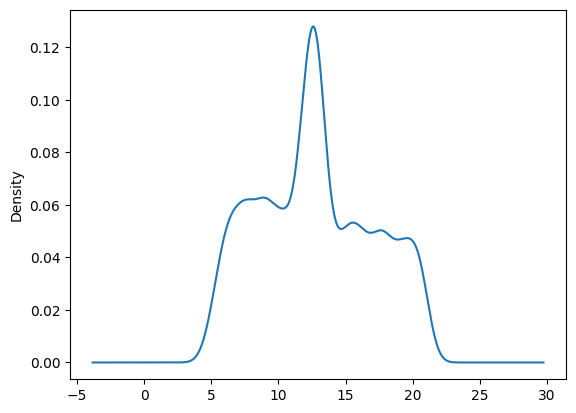

In [1563]:
full_data['Item_Weight_new'].plot(kind='kde')

In [1564]:
full_data['Item_Weight_based_on_identifier'] = full_data['Item_Weight'].fillna(
    full_data.groupby('Item_Identifier')['Item_Weight'].transform('mean')
)
full_data['Item_Weight_based_on_identifier'] = full_data['Item_Weight_based_on_identifier'].fillna(
    full_data.groupby(['Item_Identifier_catagory', 'Item_Type'])['Item_Weight_based_on_identifier'].transform('mean'))

<Axes: ylabel='Density'>

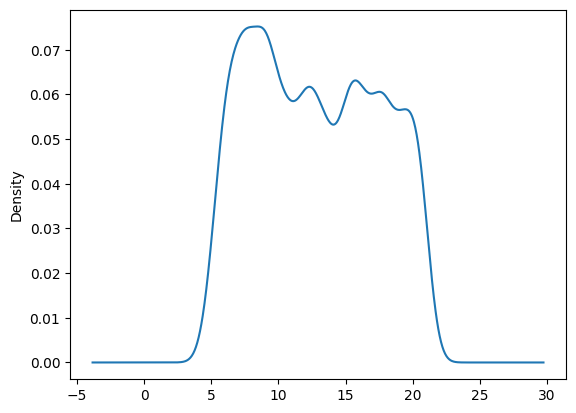

In [1565]:
full_data['Item_Weight_based_on_identifier'].plot(kind='kde')

In [1566]:
full_data['Item_Fat_Content'] = full_data['Item_Fat_Content'].map({
    'Low Fat': 'Low Fat',
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular',
    'Regular': 'Regular'
})

In [1567]:
full_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    9185
Regular    5019
Name: count, dtype: int64

In [1568]:
full_data['Item_Visibility'].value_counts()

Item_Visibility
0.000000    879
0.076841      3
0.077011      3
0.077169      3
0.076792      3
           ... 
0.162572      1
0.014826      1
0.058034      1
0.043786      1
0.104720      1
Name: count, Length: 13006, dtype: int64

<Axes: ylabel='Density'>

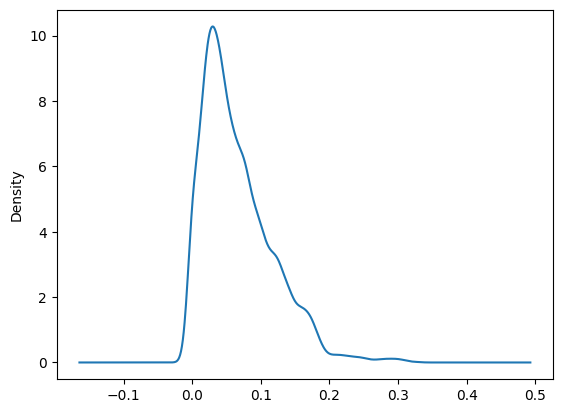

In [1569]:
full_data['Item_Visibility'].plot(kind = 'kde')

In [1570]:
full_data['Item_Visibility'].median()

np.float64(0.054020536499999994)

In [1571]:
full_data['Item_Visibility']=full_data['Item_Visibility'].replace(to_replace=0.000000,value=np.nan)

In [1572]:
full_data['Item_Visibility'].value_counts()

Item_Visibility
0.077169    3
0.076841    3
0.076483    3
0.077290    3
0.076856    3
           ..
0.162572    1
0.014826    1
0.058034    1
0.043786    1
0.104720    1
Name: count, Length: 13005, dtype: int64

In [1573]:

full_data['Item_Visibility_new']= full_data['Item_Visibility'].fillna(test.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))

In [1574]:
full_data['Item_Visibility_median']= full_data['Item_Visibility'].fillna(full_data['Item_Visibility'].median())

<Axes: ylabel='Density'>

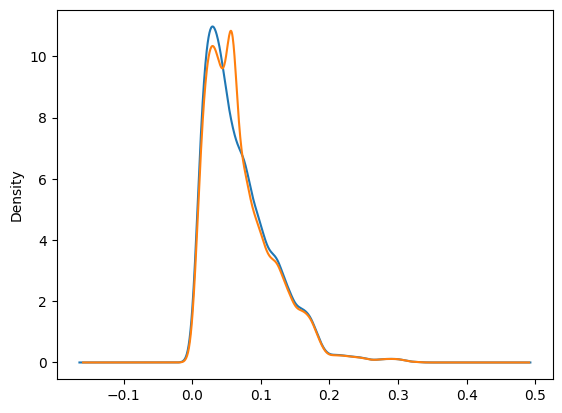

In [1575]:
full_data['Item_Visibility_new'].plot(kind = 'kde')
full_data['Item_Visibility_median'].plot(kind = 'kde')

In [1576]:
full_data['Outlet_Establishment_Year_new'] = date.today().year-full_data['Outlet_Establishment_Year']
pivot_output = full_data.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = (lambda x:x.mode()[0]))
missing_val = full_data['Outlet_Size'].isnull()
full_data.loc[missing_val,'Outlet_Size']= full_data.loc[missing_val,'Outlet_Type'].apply(lambda x:pivot_output[x])

In [1577]:
full_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_catagory,Item_Weight_new,Item_Weight_based_on_identifier,Item_Visibility_new,Item_Visibility_median,Outlet_Establishment_Year_new
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD,9.30,9.30,0.016047,0.016047,26
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR,5.92,5.92,0.019278,0.019278,16
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,FD,17.50,17.50,0.016760,0.016760,26
3,FDX07,19.20,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,FD,19.20,19.20,0.015302,0.057851,27
4,NCD19,8.93,Low Fat,NaN,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,NC,8.93,8.93,0.119148,0.057851,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.50,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN,FD,10.50,10.50,0.013496,0.013496,28
5677,FDD47,7.60,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN,FD,7.60,7.60,0.142991,0.142991,16
5678,NCO17,10.00,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,Small,Tier 2,Supermarket Type1,NaN,NC,10.00,10.00,0.073529,0.073529,23
5679,FDJ26,15.30,Regular,NaN,Canned,214.6218,OUT017,2007,Small,Tier 2,Supermarket Type1,NaN,FD,15.30,15.30,0.091977,0.057851,18


In [1578]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14204 entries, 0 to 5680
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  14204 non-null  object 
 1   Item_Weight                      11765 non-null  float64
 2   Item_Fat_Content                 14204 non-null  object 
 3   Item_Visibility                  13325 non-null  float64
 4   Item_Type                        14204 non-null  object 
 5   Item_MRP                         14204 non-null  float64
 6   Outlet_Identifier                14204 non-null  object 
 7   Outlet_Establishment_Year        14204 non-null  int64  
 8   Outlet_Size                      14204 non-null  object 
 9   Outlet_Location_Type             14204 non-null  object 
 10  Outlet_Type                      14204 non-null  object 
 11  Item_Outlet_Sales                8523 non-null   float64
 12  Item_Identifier_catagory

In [1579]:
select_col= full_data[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Identifier','Item_Outlet_Sales']]

In [1580]:
select_col

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Item_Outlet_Sales
0,FD,9.30,Low Fat,0.016047,Dairy,249.8092,26,Medium,Tier 1,Supermarket Type1,OUT049,3735.1380
1,DR,5.92,Regular,0.019278,Soft Drinks,48.2692,16,Medium,Tier 3,Supermarket Type2,OUT018,443.4228
2,FD,17.50,Low Fat,0.016760,Meat,141.6180,26,Medium,Tier 1,Supermarket Type1,OUT049,2097.2700
3,FD,19.20,Regular,0.015302,Fruits and Vegetables,182.0950,27,Small,Tier 3,Grocery Store,OUT010,732.3800
4,NC,8.93,Low Fat,0.119148,Household,53.8614,38,High,Tier 3,Supermarket Type1,OUT013,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
5676,FD,10.50,Regular,0.013496,Snack Foods,141.3154,28,Small,Tier 1,Supermarket Type1,OUT046,NaN
5677,FD,7.60,Regular,0.142991,Starchy Foods,169.1448,16,Medium,Tier 3,Supermarket Type2,OUT018,NaN
5678,NC,10.00,Low Fat,0.073529,Health and Hygiene,118.7440,23,Small,Tier 2,Supermarket Type1,OUT045,NaN
5679,FD,15.30,Regular,0.091977,Canned,214.6218,18,Small,Tier 2,Supermarket Type1,OUT017,NaN


In [1581]:
catagorical_columns_list = ['Item_Identifier_catagory','Item_Identifier_catagory','Item_Fat_Content','Item_Type','Outlet_Type','Outlet_Location_Type','Outlet_Size','Outlet_Identifier']
numerical_columns_list = ['Item_Weight_based_on_identifier','Item_Visibility_new','Outlet_Establishment_Year_new','Item_MRP','Item_Outlet_Sales']

In [1582]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [1583]:
for i in catagorical_columns_list:
    select_col[i] = le.fit_transform(select_col[i])

/var/folders/wn/81srscj53qq1qb7nwhl96jr00000gn/T/ipykernel_83843/1975200279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_col[i] = le.fit_transform(select_col[i])
/var/folders/wn/81srscj53qq1qb7nwhl96jr00000gn/T/ipykernel_83843/1975200279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_col[i] = le.fit_transform(select_col[i])
/var/folders/wn/81srscj53qq1qb7nwhl96jr00000gn/T/ipykernel_83843/1975200279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [1584]:
select_col

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Item_Outlet_Sales
0,1,9.30,0,0.016047,4,249.8092,26,1,0,1,9,3735.1380
1,0,5.92,1,0.019278,14,48.2692,16,1,2,2,3,443.4228
2,1,17.50,0,0.016760,10,141.6180,26,1,0,1,9,2097.2700
3,1,19.20,1,0.015302,6,182.0950,27,2,2,0,0,732.3800
4,2,8.93,0,0.119148,9,53.8614,38,0,2,1,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
5676,1,10.50,1,0.013496,13,141.3154,28,2,0,1,8,NaN
5677,1,7.60,1,0.142991,15,169.1448,16,1,2,2,3,NaN
5678,2,10.00,0,0.073529,8,118.7440,23,2,1,1,7,NaN
5679,1,15.30,1,0.091977,3,214.6218,18,2,1,1,2,NaN


In [5369]:
select_col[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Outlet_Sales']].corr()['Item_Outlet_Sales']

Item_Identifier_catagory           0.011236
Item_Weight_based_on_identifier    0.013261
Item_Fat_Content                   0.018719
Item_Visibility_new               -0.131327
Item_Type                          0.017048
Item_MRP                           0.567574
Outlet_Establishment_Year_new      0.049135
Outlet_Size                       -0.162753
Outlet_Location_Type               0.089367
Outlet_Type                        0.401522
Item_Outlet_Sales                  1.000000
Name: Item_Outlet_Sales, dtype: float64

In [1585]:
train_sam = select_col[0:len_train]
test_sam = select_col[len_train:14204].drop('Item_Outlet_Sales',axis = 1)

In [1586]:
test_sam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier_catagory         5681 non-null   int64  
 1   Item_Weight_based_on_identifier  5681 non-null   float64
 2   Item_Fat_Content                 5681 non-null   int64  
 3   Item_Visibility_new              5681 non-null   float64
 4   Item_Type                        5681 non-null   int64  
 5   Item_MRP                         5681 non-null   float64
 6   Outlet_Establishment_Year_new    5681 non-null   int64  
 7   Outlet_Size                      5681 non-null   int64  
 8   Outlet_Location_Type             5681 non-null   int64  
 9   Outlet_Type                      5681 non-null   int64  
 10  Outlet_Identifier                5681 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 532.6 KB


In [1587]:
train_sam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier_catagory         8523 non-null   int64  
 1   Item_Weight_based_on_identifier  8523 non-null   float64
 2   Item_Fat_Content                 8523 non-null   int64  
 3   Item_Visibility_new              8343 non-null   float64
 4   Item_Type                        8523 non-null   int64  
 5   Item_MRP                         8523 non-null   float64
 6   Outlet_Establishment_Year_new    8523 non-null   int64  
 7   Outlet_Size                      8523 non-null   int64  
 8   Outlet_Location_Type             8523 non-null   int64  
 9   Outlet_Type                      8523 non-null   int64  
 10  Outlet_Identifier                8523 non-null   int64  
 11  Item_Outlet_Sales                8523 non-null   float64
dtypes: float64(4), int64(8)
m

In [ ]:
# train test split

In [2988]:
train_final= train_sam[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [2989]:
train_output = train_sam['Item_Outlet_Sales']

In [2990]:
# train_output = np.log1p(train_sam['Item_Outlet_Sales'])

In [2991]:
x_train,x_test,y_train,y_test = train_test_split(train_final,train_output,test_size= .20,random_state = 42)

In [ ]:

'subsample': 0.5,
 'reg_lambda': 20,
 'reg_alpha': 5,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.01,
 'gamma': 0.5,
 'colsample_bytree': 0.8}


In [280]:
# threshold = y_train.quantile(0.85)

In [281]:
# threshold

np.float64(3969.4996)

In [282]:
# weights = np.where(y_train > threshold, 3, 1)
# weights

array([1, 1, 1, ..., 3, 1, 1], shape=(6818,))

In [351]:
threshold = y_train.quantile(0.9)
high_sales_idx = y_train[y_train > threshold].index

In [352]:
x_train_oversampled = pd.concat([x_train, x_train.loc[high_sales_idx]], axis=0)
y_train_oversampled = pd.concat([y_train, y_train.loc[high_sales_idx]], axis=0)

In [353]:
y_train_oversampled.shape[0]

7500

In [ ]:
#Using XGBRegressor

In [1191]:
modelXGB = XGBRegressor(
    n_estimators=600,          # more boosting rounds for smoother learning
    learning_rate=0.01,         # slower learning for stability in log space
    max_depth=4,                # not too deep to avoid overfit
    min_child_weight=5,         # smaller so it can learn finer patterns
    subsample=0.4,              
    colsample_bytree=0.9,       
    reg_alpha=1,              # mild L1 regularization
    reg_lambda=1,              # reasonable L2 shrinkage
    gamma=1,                  # allow more splits
    objective='reg:squarederror',
    random_state=41
)

In [1192]:
modelXGB.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [1193]:
modelXGB.score(x_test,y_test)

0.6176127364463707

In [1194]:
y_pred = modelXGB.predict(x_test)

In [1195]:
np.sqrt(metrics.mean_squared_error(y_pred,y_test))

np.float64(1019.4690462168255)

In [1185]:
y_pred

array([1283.3363 ,  757.7203 ,  716.6744 , ...,  692.3957 ,  651.18787,
       1692.7715 ], shape=(1705,), dtype=float32)

In [423]:
y_pred1 = np.expm1(y_pred)
y_test1 = np.expm1(y_test)

In [430]:
np.sqrt(metrics.mean_squared_error(y_pred1,y_test1))

np.float64(1056.3968806751423)

In [439]:
np.min(y_pred)

np.float32(99.83219)

In [440]:
np.max(y_pred)

np.float32(6125.727)

In [441]:
np.min(y_test)

np.float64(33.29)

In [442]:
np.max(y_test)

np.float64(10236.675)

In [428]:
np.mean(y_pred)

np.float32(7.26759)

In [429]:
np.mean(y_test)

np.float64(7.251453565725218)

<Axes: ylabel='Frequency'>

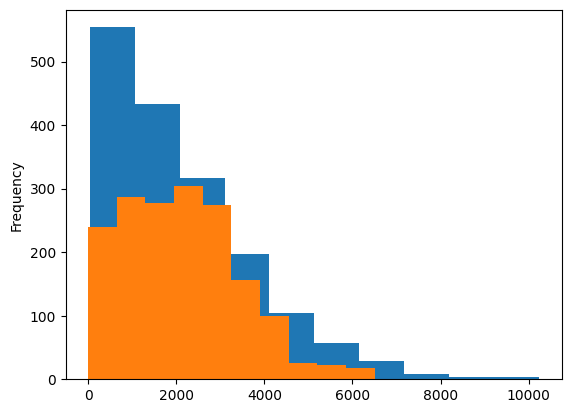

In [449]:
y_test.plot(kind = 'hist')
y_pred_series = pd.Series(y_pred)
y_pred_series.plot(kind = 'hist')
# y_train.plot(kind = 'kde')

In [ ]:
# analyzing how model is predicting vs actual

<Axes: ylabel='Frequency'>

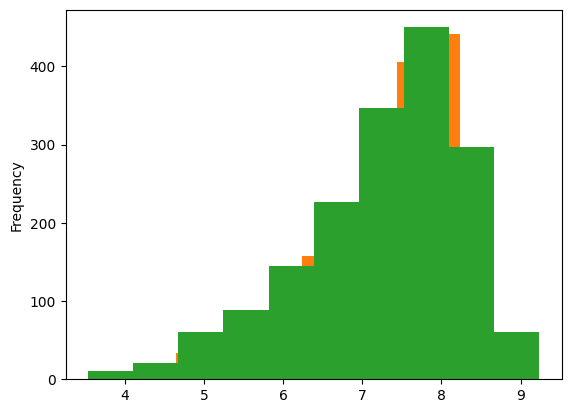

In [422]:
y_test.plot(kind = 'hist')
y_pred_series = pd.Series(y_pred)
y_pred_series.plot(kind = 'hist')
y_test.plot(kind = 'hist')

In [1402]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 6818 entries, 549 to 7270
Series name: Item_Outlet_Sales
Non-Null Count  Dtype  
--------------  -----  
6818 non-null   float64
dtypes: float64(1)
memory usage: 106.5 KB


In [ ]:
#Using Random forest

In [2992]:
rf = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=7,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=84, min_samples_split=95,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)

In [2993]:
rf.fit(x_train,y_train)

,n_estimators,90
,criterion,'squared_error'
,max_depth,7
,min_samples_split,95
,min_samples_leaf,84
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [3924]:
rf.score(x_test,y_test)

0.6208176993544336

In [3921]:
y_pred = rf.predict(x_test)

In [3922]:
# all_tree_preds = np.array([rf.predict(x_test) for tree in rf.estimators_])

# # Take median across trees
# y_pred_median = np.median(all_tree_preds, axis=0)
# print(y_pred_median)

In [3923]:
np.sqrt(metrics.mean_squared_error(y_pred*(.991),y_test))

np.float64(1014.915003513215)

In [1675]:
train_sam

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Item_Outlet_Sales
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1,9,3735.1380
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2,3,443.4228
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1,9,2097.2700
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0,0,732.3800
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1,1,2778.3834
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1,7,549.2850
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1,6,1193.1136
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2,3,1845.5976


In [3843]:
train_final= train_sam[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [3844]:
testing_output = train_sam['Item_Outlet_Sales']

In [3845]:
train_final['Item_MRP'].corr(train_sam['Item_Outlet_Sales'])

np.float64(0.5675744466569197)

In [3846]:
whole_predict = rf.predict(train_final)

In [3847]:
whole_predict

array([4278.60729842,  733.6233244 , 2152.63735898, ..., 1382.473597  ,
       1640.43694553, 1146.17636763], shape=(8523,))

In [3848]:
train_output

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [3849]:
np.sqrt(metrics.mean_squared_error(whole_predict*(.991),train_output))

np.float64(1065.230785336903)

In [3850]:
residuals = train_output-whole_predict
residuals

0       -543.469298
1       -290.200524
2        -55.367359
3        269.441738
4         30.181074
           ...     
8518    -625.485098
8519   -1147.073942
8520    -189.359997
8521     205.160654
8522    -380.506368
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [3851]:
residuals.max()

np.float64(7159.80897432692)

In [3854]:
train_final

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1,4278.607298
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2,733.623324
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1,2152.637359
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0,462.938262
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1,964.524126
...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1,3403.868498
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1,1696.358942
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1,1382.473597
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2,1640.436946


In [3853]:
train_final['Item_Outlet_Sales'] = rf.predict(train_final)

/var/folders/wn/81srscj53qq1qb7nwhl96jr00000gn/T/ipykernel_83843/538269938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final['Item_Outlet_Sales'] = rf.predict(train_final)


In [ ]:
#############################

In [4026]:
# trying to create a classification model to identify residual direction
y_sign = np.sign(residuals)
clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=6,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=1,
           oob_score=False, random_state=42, verbose=0).fit(train_final, y_sign)

In [3858]:
y_mag = np.abs(residuals)
rf_abs = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=6,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=1,
           oob_score=False, random_state=42, verbose=0).fit(train_final, y_mag)

In [ ]:
sign_pred = clf.predict(X_new)
mag_pred = reg.predict(X_new)
residual_pred = sign_pred * mag_pred

In [ ]:
##############

In [4218]:
rf1 = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=6,
         max_leaf_nodes=None,
           min_impurity_decrease=0, 
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0, n_estimators=95, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)

In [4219]:
rf1.fit(train_final,residuals)

,n_estimators,95
,criterion,'squared_error'
,max_depth,6
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0
,bootstrap,True
,oob_score,False


In [3008]:
train_final

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1,4278.607298
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2,733.623324
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1,2152.637359
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0,462.938262
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1,964.524126
...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1,3403.868498
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1,1696.358942
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1,1382.473597
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2,1640.436946


In [3860]:
sign_pred = clf.predict(train_final)
mag_pred = rf_abs.predict(train_final)
residual_pred = sign_pred * mag_pred

In [3861]:
np.sqrt(metrics.mean_squared_error((train_final['Item_Outlet_Sales']+residual_pred),train_output))


np.float64(620.4616837414125)

In [3009]:
residual_pred = rf1.predict(train_final)

In [3010]:
residual_pred.max()

np.float64(2515.701442367438)

In [3037]:
np.sqrt(metrics.mean_squared_error((train_final['Item_Outlet_Sales']+residual_pred),train_output))

np.float64(1031.5187285622546)

In [3125]:
np.mean(residuals/residual_pred)

np.float64(80.08277774321462)

In [3032]:
residuals.mean()

np.float64(-4.834523714641647)

In [3036]:
residual_pred.mean()*1.07

np.float64(-4.842620451042329)

<Axes: ylabel='Frequency'>

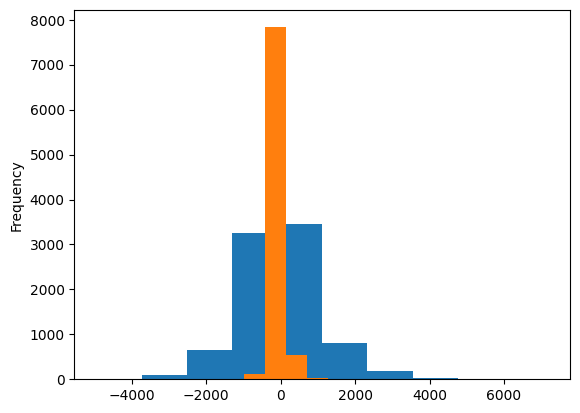

In [2135]:
residuals_fit = pd.Series(residuals)
residuals_fit.plot(kind = 'hist')

residual_model = pd.Series(residual_pred)
residual_model.plot(kind = 'hist')


In [2133]:
df = pd.DataFrame({
    
    'actual': residuals,
    'pred': residual_pred
})

In [2134]:
df.to_csv("test.csv", index=False)

In [ ]:
#gradientboost

In [1882]:
residuals.info()

<class 'pandas.core.series.Series'>
Index: 8523 entries, 0 to 8522
Series name: Item_Outlet_Sales
Non-Null Count  Dtype  
--------------  -----  
8523 non-null   float64
dtypes: float64(1)
memory usage: 133.2 KB


In [2121]:
XGB = XGBRegressor(
    n_estimators=80,          # more boosting rounds for smoother learning
    learning_rate=0.2,         # slower learning for stability in log space
    max_depth=4,                # not too deep to avoid overfit
    min_child_weight=5,         # smaller so it can learn finer patterns
    subsample=0.5,              
    colsample_bytree=0.9,       
    reg_alpha=1,              # mild L1 regularization
    reg_lambda=1,              # reasonable L2 shrinkage
    gamma=1,                  # allow more splits
    objective='reg:squarederror',
    random_state=41
)

In [2122]:
XGB.fit(train_final,residuals)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [2123]:
train_final

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1,4263.895230
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2,734.153384
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1,2144.218878
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0,462.448183
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1,965.406299
...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1,3405.859049
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1,1695.697417
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1,1386.652727
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2,1637.693121


In [2124]:
residual_xgb = XGB.predict(train_final)

<Axes: ylabel='Frequency'>

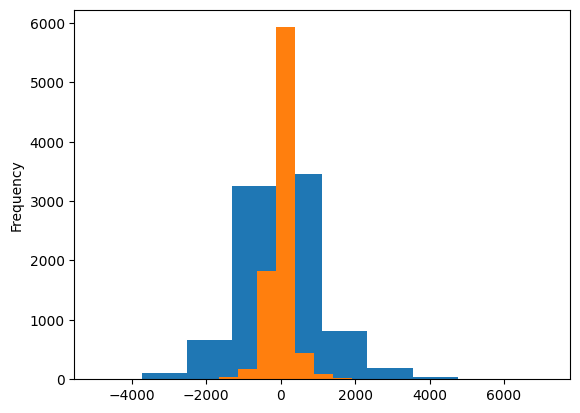

In [2125]:
residuals_fit = pd.Series(residuals)
residuals_fit.plot(kind = 'hist')

residual_model = pd.Series(residual_xgb)
residual_model.plot(kind = 'hist')

In [2126]:
np.sqrt(metrics.mean_squared_error((train_final['Item_Outlet_Sales']+residual_xgb),train_output))

np.float64(963.5308915945908)

In [2290]:
# new Approach cretate classification

In [2455]:
train_final
residuals = train_output-whole_predict
residue_final=train_final
residue_final['residuals'] = residuals 
# def test(x):
#     if x<0 and x>-1000:
#         return 'greaterthan-1000'
#     if x<0 and x<-1000:
#         return 'lessthan-1000'
#     if x>0 and x<1000:
#         return 'lessthan1000'
#     if x>0 and x>1000:
#         return 'greaterthan1000'

def test(x):
    if x<0:
        return -250
    if x>0:
        return 250


residue_final['class'] = residue_final['residuals'].apply(test)
# residue_final['class'] = residue_final['class'].map({
#     'greaterthan-1000': -500,
#     'lessthan-1000': -1500,
#     'lessthan1000': 500,
#     'greaterthan1000': 1500,
    
# })
residue_final

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,residuals,class,predicted_class
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1,4263.895230,-528.757230,-250,-200
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2,734.153384,-290.730584,-250,-200
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1,2144.218878,-46.948878,-250,-200
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0,462.448183,269.931817,250,200
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1,965.406299,29.298901,250,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1,3405.859049,-627.475649,-250,-200
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1,1695.697417,-1146.412417,-250,-200
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1,1386.652727,-193.539127,-250,-200
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2,1637.693121,207.904479,250,200


In [2456]:
rfresiduals = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=20,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
rfresiduals.fit(residue_final[['Item_Outlet_Sales','Item_MRP']],residue_final[['class']])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [2457]:
residue_final['predicted_class']=rfresiduals.predict(residue_final[['Item_Outlet_Sales','Item_MRP']])
metrics.accuracy_score(residue_final[['class']],residue_final['predicted_class'])

# residue_final['predicted_class'].value_counts()

0.9439164613399038

In [2458]:
np.sqrt(metrics.mean_squared_error((train_final['Item_Outlet_Sales']+residue_final['predicted_class'])*(1),train_output))

np.float64(931.5483562719318)

In [2240]:
df_residuals = pd.DataFrame({
    
    'residuals': residuals,
    
})

In [2241]:
def test(x):
    if x<0 and x>-1000:
        return 'greaterthan-1000'
    if x<0 and x<-1000:
        return 'lessthan-1000'
    if x>0 and x<1000:
        return 'lessthan1000'
    if x>0 and x>1000:
        return 'greaterthan1000'

In [2242]:
df_residuals['class'] = df_residuals['residuals'].apply(test)

In [2243]:
df_residuals

,residuals,class
0,-528.757230,greaterthan-1000
1,-290.730584,greaterthan-1000
2,-46.948878,greaterthan-1000
3,269.931817,lessthan1000
4,29.298901,lessthan1000
...,...,...
8518,-627.475649,greaterthan-1000
8519,-1146.412417,lessthan-1000
8520,-193.539127,greaterthan-1000
8521,207.904479,lessthan1000


In [2244]:
df_residuals['class'] = df_residuals['class'].map({
    'greaterthan-1000': 0,
    'lessthan-1000': 1,
    'lessthan1000': 2,
    'greaterthan1000': 3,
    
})

In [2245]:
rfclass = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=7,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)

In [2248]:
df_residuals

,residuals,class
0,-528.757230,0
1,-290.730584,0
2,-46.948878,0
3,269.931817,2
4,29.298901,2
...,...,...
8518,-627.475649,0
8519,-1146.412417,1
8520,-193.539127,0
8521,207.904479,2


In [2249]:
x=df_residuals['residuals']
y=df_residuals['class']

In [2253]:
rfclass.fit(x.values.reshape(-1, 1),y)

,n_estimators,100
,criterion,'gini'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [2262]:
residual_class = rfclass.predict(x.values.reshape(-1, 1))

In [2264]:
df_residuals

,residuals,class
0,-528.757230,0
1,-290.730584,0
2,-46.948878,0
3,269.931817,2
4,29.298901,2
...,...,...
8518,-627.475649,0
8519,-1146.412417,1
8520,-193.539127,0
8521,207.904479,2


In [2265]:
final = df_residuals

In [2266]:
final['class_predicted']= residual_class

In [2268]:
final

,residuals,class,class_predicted
0,-528.757230,0,0
1,-290.730584,0,0
2,-46.948878,0,0
3,269.931817,2,2
4,29.298901,2,2
...,...,...,...
8518,-627.475649,0,0
8519,-1146.412417,1,1
8520,-193.539127,0,0
8521,207.904479,2,2


In [2270]:
def put_residual_value(val):
    if val == 0:
        return -500
    if val == 1:
        return -1500
    if val == 2:
        return 500
    if val == 3:
        return 1500
final['class_predicted'] = final['class_predicted'].apply(put_residual_value)

In [2281]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, 0 to 8522
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   residuals        8523 non-null   float64
 1   class            8523 non-null   int64  
 2   class_predicted  8523 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 266.3 KB


In [2280]:
train_final
    

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1,4263.895230
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2,734.153384
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1,2144.218878
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0,462.448183
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1,965.406299
...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1,3405.859049
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1,1695.697417
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1,1386.652727
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2,1637.693121


In [2283]:
np.sqrt(metrics.mean_squared_error((train_final['Item_Outlet_Sales']+final['class_predicted']),train_output))

np.float64(475.4155848008997)

In [2282]:
train_output

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [1614]:
x_test

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type
7503,1,14.300,0,0.026300,5,79.4302,38,0,2,1
2957,2,7.930,0,0.071136,8,42.7086,28,2,0,1
7031,1,14.500,1,0.041313,3,42.0454,26,1,0,1
1084,0,13.000,1,0.044767,14,173.7054,40,1,2,3
856,1,10.195,1,0.012456,10,197.5110,21,2,1,1
...,...,...,...,...,...,...,...,...,...,...
7205,1,11.800,1,0.093656,13,127.1704,28,2,0,1
3257,1,7.020,0,0.078957,6,148.1734,16,1,2,2
6346,1,14.500,1,0.041215,3,42.0454,38,0,2,1
6318,1,9.800,1,0.141184,0,50.5008,16,1,2,2


In [3711]:
testing_final= train_sam[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]
testing_output = train_sam['Item_Outlet_Sales']
testing_final['Item_Outlet_Sales'] = rf.predict(testing_final)
residuals = testing_output-testing_final['Item_Outlet_Sales']
# x_train,x_test,y_train,y_test = train_test_split(testing_final,testing_output,test_size= .20,random_state = 42)


rf2 = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=6,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
rf2.fit(testing_final[['Item_MRP','Item_Outlet_Sales']],residuals)

/var/folders/wn/81srscj53qq1qb7nwhl96jr00000gn/T/ipykernel_83843/4038449137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_final['Item_Outlet_Sales'] = rf.predict(testing_final)


,n_estimators,95
,criterion,'squared_error'
,max_depth,6
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5344]:
test_sam = select_col[len_train:14204].drop('Item_Outlet_Sales',axis = 1)
test_sam = test_sam[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [5345]:
y_pred = rf.predict(test_sam)
test_sam['Item_Outlet_Sales']=y_pred
# rfclass

In [5346]:
residualpred = rf1.predict(test_sam)
# residualpred = XGB.predict(test_sam)
# residualpred=rfresiduals.predict(test_sam[['Item_Outlet_Sales','Item_MRP']])
# residualpred = rf2.predict(test_sam[['Item_MRP','Item_Outlet_Sales']])
# sign_pred = clf.predict(test_sam)
# mag_pred = rf_abs.predict(test_sam)
# residualpred = sign_pred * mag_pred

In [5347]:
testing = pd.read_csv("test_AbJTz2l.csv")

In [5348]:
test_sam['residuals']= residualpred
# test_sam['sign_pred']= sign_pred

# def signresidual(val):
#     sign,resid = val
#     if resid<0 and sign==-1:
#         return resid
#     if resid>0 and sign==1:
#         return resid
#     if resid>0 and sign==-1:
#         return resid*sign
#     else:
#         return -resid
        
# test_sam['residuals']= test_sam[['sign_pred','residuals']].apply(signresidual,axis = 1)

In [5349]:
test_sam['Item_Outlet_Sales'] =  test_sam['residuals']+test_sam['Item_Outlet_Sales']

In [5350]:
test_sam.drop('residuals',axis = 1,inplace=True)

In [5351]:
test_sam[test_sam['Item_Outlet_Sales']<0]

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [5352]:
testing['Item_Outlet_Sales'] = test_sam['Item_Outlet_Sales']

In [5353]:
testing[testing['Item_Outlet_Sales']<0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [5354]:
df = testing[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]

In [5355]:
df['Item_Outlet_Sales']=df['Item_Outlet_Sales']

/var/folders/wn/81srscj53qq1qb7nwhl96jr00000gn/T/ipykernel_83843/2500987287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item_Outlet_Sales']=df['Item_Outlet_Sales']-5


<Axes: >

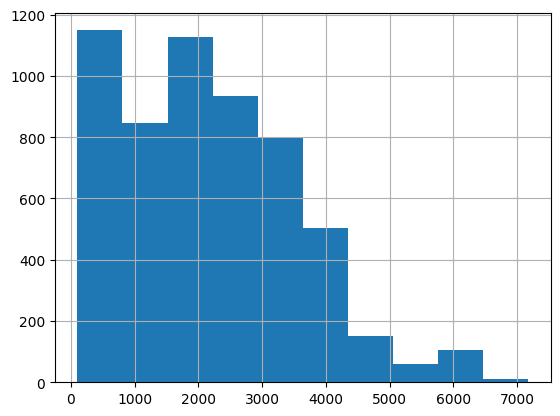

In [5356]:
df['Item_Outlet_Sales'].hist()

In [5357]:
df.sort_values(by='Item_Outlet_Sales', ascending=True)

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
3604,FDA39,OUT019,102.328333
4250,FDY52,OUT010,105.407736
4772,FDK36,OUT010,107.140771
3292,FDY36,OUT010,109.651632
4317,FDF09,OUT010,118.995230
...,...,...,...
4086,FDI09,OUT027,6667.277750
5615,FDF04,OUT027,6669.491750
2169,NCV53,OUT027,6736.515880
2634,NCZ42,OUT027,6768.021731


<Axes: >

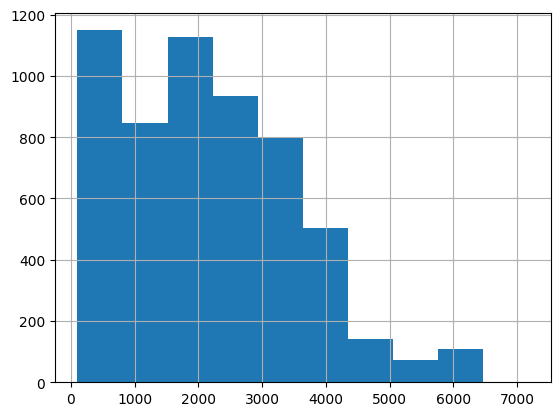

In [5360]:
df['Item_Outlet_Sales'].hist()

In [5361]:
df

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1560.858025
1,FDW14,OUT017,1427.349725
2,NCN55,OUT010,499.845005
3,FDQ58,OUT017,2470.882211
4,FDY38,OUT027,5706.446836
...,...,...,...
5676,FDB58,OUT046,2113.008963
5677,FDD47,OUT018,2293.868049
5678,NCO17,OUT045,1916.837863
5679,FDJ26,OUT017,3727.996104


In [5370]:
df.to_csv("residualclassify_solution.csv", index=False)## Final CSV

In [4683]:
df.sort_values(by='Item_Outlet_Sales', ascending=True)

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
3604,FDA39,OUT019,122.328333
4250,FDY52,OUT010,125.407736
4772,FDK36,OUT010,127.140771
3292,FDY36,OUT010,129.651632
4317,FDF09,OUT010,138.995230
...,...,...,...
4086,FDI09,OUT027,6667.277750
5615,FDF04,OUT027,6669.491750
2169,NCV53,OUT027,6736.515880
2634,NCZ42,OUT027,6768.021731


In [1516]:
np.sqrt(metrics.mean_squared_error(y_pred,y_test))

np.float64(6283.485325905752)

In [1286]:
np.mean(y_pred),np.min(y_pred),np.max(y_pred)

(np.float64(2120.5716095886078),
 np.float64(137.84316266669092),
 np.float64(5899.2297459032225))

In [698]:
np.mean(y_test),np.min(y_test),np.max(y_test)

(np.float64(2097.0083659824045), np.float64(33.29), np.float64(10236.675))

In [1385]:
df = pd.DataFrame({
    'mrp' : x_test['Item_MRP'],
    'y_test': y_test,
    'y_pred': y_pred
})

In [1386]:
df.to_csv("check.csv", index=False)

In [1357]:
np.mean(y_pred/y_test)

np.float64(1.3451712676853602)

In [1358]:
np.mean(y_test/y_pred)

np.float64(0.9828692173654311)

<Axes: ylabel='Frequency'>

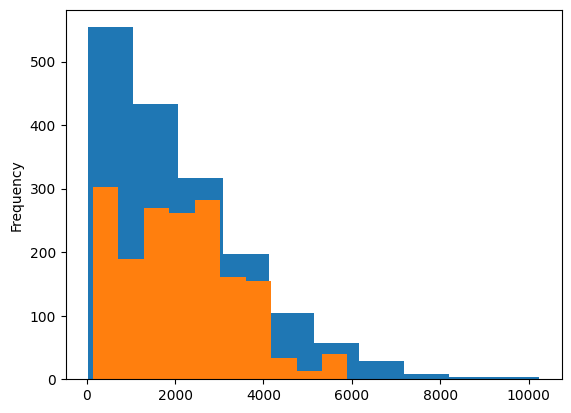

In [717]:
y_test.plot(kind = 'hist')
# y_pred_median_series = pd.Series(y_pred_median)
# y_pred_median_series.plot(kind = 'hist')
y_pred_series = pd.Series(y_pred)
y_pred_series.plot(kind = 'hist')
# y_train.plot(kind = 'kde')

In [631]:
residuals = y_test - y_pred

<Axes: ylabel='Frequency'>

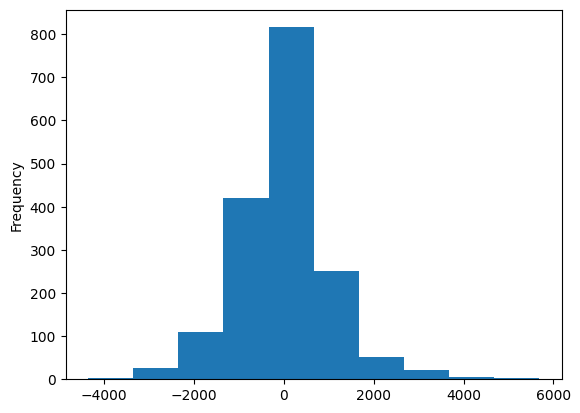

In [632]:
residuals.plot(kind = 'hist')

In [633]:
import pandas as pd
from scipy.stats import skew

# Assuming residuals = y_test - y_pred

# Using pandas
residuals_series = pd.Series(residuals)
print("Residual skew (pandas):", residuals_series.skew())

Residual skew (pandas): 0.5392305692525713


In [741]:
test= select_col[select_col['Item_Outlet_Sales'].notnull()]

In [740]:
test[test['Item_MRP']<90]['Item_Outlet_Sales'].mean()

np.float64(909.098333468766)

In [743]:
test[(test['Item_MRP'] > 90) & (test['Item_MRP'] < 180)]['Item_Outlet_Sales'].mean()

np.float64(2074.8838446272994)

In [744]:
test[(test['Item_MRP'] > 180) & (test['Item_MRP'] < 270)]['Item_Outlet_Sales'].mean()

np.float64(3397.064717506193)

In [1091]:
train_final= train_sam[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]
train_output = train_sam['Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(train_final,train_output,test_size= .20,random_state = 42)

low_mrp = x_train[x_train['Item_MRP']<90]
medium_mrp = x_train[(x_train['Item_MRP'] > 90) & (x_train['Item_MRP'] < 180)]
high_mrp = x_train[x_train['Item_MRP']>180]

#  MRP
y_train_low = y_train[low_mrp.index]

# Medium MRP
y_train_medium = y_train[medium_mrp.index]

# High MRP
y_train_high = y_train[high_mrp.index]

In [1092]:
y_train_low.mean()

np.float64(913.6749530089628)

In [1093]:
y_train_medium.mean()

np.float64(2094.892782574136)

In [1094]:
y_train_high.mean()

np.float64(3393.5373188916874)

In [1095]:
rf_low= RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=5,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=85, min_samples_split=85,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
rf_low.fit(low_mrp,y_train_low)

,n_estimators,300
,criterion,'squared_error'
,max_depth,5
,min_samples_split,85
,min_samples_leaf,85
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1096]:
rf_med= RandomForestRegressor(bootstrap=True, criterion='squared_error', 
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
rf_med.fit(medium_mrp,y_train_medium)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1097]:
rf_high= RandomForestRegressor(bootstrap=True, criterion='squared_error', 
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
rf_high.fit(high_mrp,y_train_high)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1098]:
low_mrp_test = x_test[x_test['Item_MRP']<90]
medium_mrp_test = x_test[(x_test['Item_MRP'] > 90) & (x_test['Item_MRP'] < 180)]
high_mrp_test = x_test[x_test['Item_MRP']>180]

# Low MRP
y_test_low = y_test[low_mrp_test.index]

# Medium MRP
y_test_medium = y_test[medium_mrp_test.index]

# High MRP
y_test_high = y_test[high_mrp_test.index]

In [1099]:
rf_low.score(low_mrp_test,y_test_low)

0.4795273085686095

In [1100]:
rf_med.score(medium_mrp_test,y_test_medium)

0.3957735858568956

In [1101]:
rf_high.score(high_mrp_test,y_test_high)

0.31178743154122934

In [904]:
pred_low = rf_low.predict(low_mrp_test)

In [905]:
np.sqrt(metrics.mean_squared_error(pred_low,y_test_low))

np.float64(450.3714419482417)

In [906]:
pred_mid = rf_low.predict(medium_mrp_test)
np.sqrt(metrics.mean_squared_error(pred_mid,y_test_medium))

np.float64(1206.1665712063389)

In [907]:
pred_high = rf_low.predict(high_mrp_test)
np.sqrt(metrics.mean_squared_error(pred_high,y_test_high))

np.float64(2655.4751006223937)

In [922]:
train_sam

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Item_Outlet_Sales
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1,9,3735.1380
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2,3,443.4228
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1,9,2097.2700
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0,0,732.3800
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1,1,2778.3834
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1,7,549.2850
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1,6,1193.1136
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2,3,1845.5976


<Axes: xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

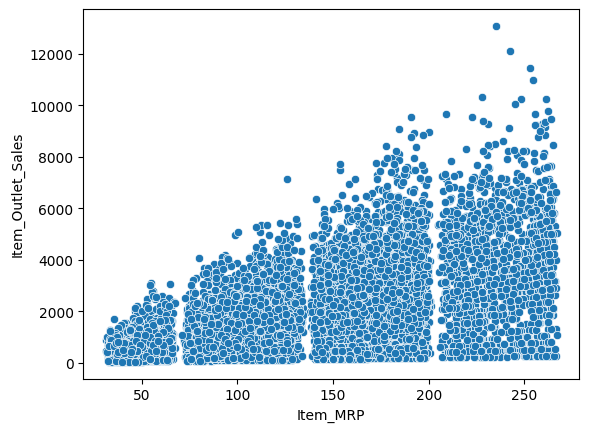

In [924]:
sns.scatterplot(data = train_sam, x='Item_MRP', y='Item_Outlet_Sales')

<Axes: xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

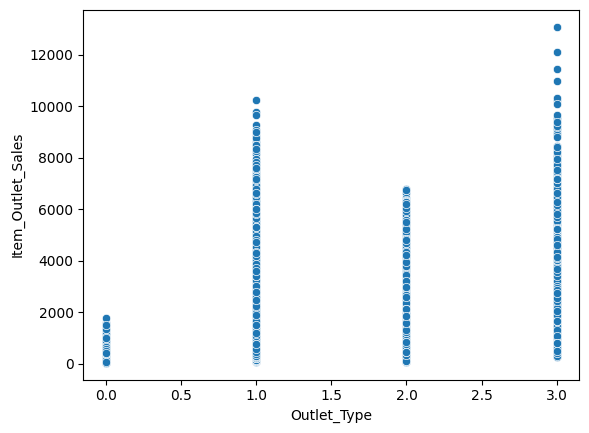

In [925]:
sns.scatterplot(data = train_sam, x='Outlet_Type', y='Item_Outlet_Sales')

In [1122]:
train_sam_two_col = train_sam[['Outlet_Type','Item_MRP','Outlet_Size','Item_Visibility_new']]

In [1123]:
train_output = train_sam['Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(train_sam_two_col,train_output,test_size= .20,random_state = 42)

In [1124]:
rf = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=5,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=85, min_samples_split=85,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)
rf.fit(x_train,y_train)

,n_estimators,400
,criterion,'squared_error'
,max_depth,5
,min_samples_split,85
,min_samples_leaf,85
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1125]:
rf.score(x_test,y_test)

0.6196127486200187

In [1126]:
pred = rf.predict(x_test)

In [1127]:
np.sqrt(metrics.mean_squared_error(pred,y_test))

np.float64(1016.7994703841066)

In [ ]:
df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

In [ ]:
#linear

In [1359]:
train_sam_two_col = train_sam[['Outlet_Type','Item_MRP']]

In [1360]:
train_sam_two_col

,Outlet_Type,Item_MRP
0,1,249.8092
1,2,48.2692
2,1,141.6180
3,0,182.0950
4,1,53.8614
...,...,...
8518,1,214.5218
8519,1,108.1570
8520,1,85.1224
8521,2,103.1332


In [1361]:
df_encoded = pd.get_dummies(train_sam_two_col['Outlet_Type'],drop_first=True)

In [1362]:
df_encoded = df_encoded.astype(int)

In [1363]:
train_sam_two_col=pd.concat([train_sam_two_col,df_encoded],axis=1)

In [1364]:
train_sam_two_col.drop('Outlet_Type',inplace = True,axis=1)

In [1365]:
train_sam_two_col

,Item_MRP,1,2,3
0,249.8092,1,0,0
1,48.2692,0,1,0
2,141.6180,1,0,0
3,182.0950,0,0,0
4,53.8614,1,0,0
...,...,...,...,...
8518,214.5218,1,0,0
8519,108.1570,1,0,0
8520,85.1224,1,0,0
8521,103.1332,0,1,0


In [1366]:
train_sam_two_col.rename(columns={1: 'x1',2:'x2',3:'x3'}, inplace=True)

In [1367]:
train_sam_two_col

,Item_MRP,x1,x2,x3
0,249.8092,1,0,0
1,48.2692,0,1,0
2,141.6180,1,0,0
3,182.0950,0,0,0
4,53.8614,1,0,0
...,...,...,...,...
8518,214.5218,1,0,0
8519,108.1570,1,0,0
8520,85.1224,1,0,0
8521,103.1332,0,1,0


In [1368]:
from sklearn.linear_model import LinearRegression,Ridge

In [1369]:
lr = LinearRegression()

In [1370]:
x_train,x_test,y_train,y_test = train_test_split(train_sam_two_col,train_output,test_size= .20,random_state = 42)

In [1371]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6818 entries, 549 to 7270
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Item_MRP  6818 non-null   float64
 1   x1        6818 non-null   int64  
 2   x2        6818 non-null   int64  
 3   x3        6818 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 266.3 KB


In [1373]:
lr.score(x_test,y_test)

0.5801186924297238

In [1382]:
rg = Ridge(0.1)
rg.fit(x_train,y_train)

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [1383]:
rg.score(x_test,y_test)

0.5801224744151492

In [1482]:
# logic to calculate outliers based on Z-score formula and a value is considered as outlier when the value lies outside
# three standered distribution

y=[]
def find_outliers(a):
    threshold=3
    mean=np.mean(a)
    std=np.std(a)
    for i in a:
        z_score=(i-mean)/std
        if abs(z_score)>threshold:
            y.append(i)
    return y
y=find_outliers(train_output)

In [1483]:
train_sam=train_sam[~train_sam['Item_Outlet_Sales'].isin(y)]

In [1484]:
train_sam

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Item_Outlet_Sales
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1,9,3735.1380
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2,3,443.4228
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1,9,2097.2700
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0,0,732.3800
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1,1,2778.3834
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1,7,549.2850
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1,6,1193.1136
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2,3,1845.5976


In [1485]:
train_final= train_sam[['Item_Identifier_catagory','Item_Weight_based_on_identifier','Item_Fat_Content','Item_Visibility_new','Item_Type',
                    'Item_MRP','Outlet_Establishment_Year_new','Outlet_Size','Outlet_Location_Type','Outlet_Type']]

In [1486]:
train_final

,Item_Identifier_catagory,Item_Weight_based_on_identifier,Item_Fat_Content,Item_Visibility_new,Item_Type,Item_MRP,Outlet_Establishment_Year_new,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,1,9.300,0,0.016047,4,249.8092,26,1,0,1
1,0,5.920,1,0.019278,14,48.2692,16,1,2,2
2,1,17.500,0,0.016760,10,141.6180,26,1,0,1
3,1,19.200,1,0.015302,6,182.0950,27,2,2,0
4,2,8.930,0,0.119148,9,53.8614,38,0,2,1
...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,0.056783,13,214.5218,38,0,2,1
8519,1,8.380,1,0.046982,0,108.1570,23,2,1,1
8520,2,10.600,0,0.035186,8,85.1224,21,2,1,1
8521,1,7.210,1,0.145221,13,103.1332,16,1,2,2


In [1487]:
train_output = train_sam['Item_Outlet_Sales']
x_train,x_test,y_train,y_test = train_test_split(train_final,train_output,test_size= .20,random_state = 42)

In [1494]:
rf = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=7,
         max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=80, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0)

In [1495]:
rf.fit(x_train,y_train)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,80
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1496]:
rf.score(x_test,y_test)

0.5995697754576337